In [1]:
# Copyright 2023 The Kubric Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
"""
Worker file for the Multi-Object Video (MOVi) C (and CC) datasets.
  * The number of objects is randomly chosen between
    --min_num_objects (3) and --max_num_objects (10)
  * The objects are randomly chosen from the Google Scanned Objects dataset

  * Background is an random HDRI from the HDRI Haven dataset,
    projected onto a Dome (half-sphere).
    The HDRI is also used for lighting the scene.
"""
import logging

import bpy
import kubric as kb
from kubric.simulator import PyBullet
from kubric.renderer import Blender
import numpy as np
from kubric import ArgumentParser
from argparse import Namespace

# local file
from kubric_helper import *


pybullet build time: Mar 26 2022 03:01:35
/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
# --- Some configuration values
# the region in which to place objects [(min), (max)]
SPAWN_REGION   = [(-5, -5, 1), (5, 5, 5)]
VELOCITY_RANGE = [(-4., -4., 0.), (4., 4., 0.)]

FLAGS = Namespace(
    resolution  = 256, 
    frame_rate  = 12, 
    step_rate   = 240, 
    frame_start = 20, 
    frame_end   = 24, #24 
    logging_level = 'INFO', 
    seed = None, 
    scratch_dir = '/tmp/tmp82v1zpil', 
    job_dir     = 'output', 
    objects_split = 'train', 
    min_num_objects = 3, 
    max_num_objects = 10, 
    floor_friction    = 0.3, 
    floor_restitution = 0.5, 
    backgrounds_split = 'train', 
    camera = 'fixed_random', 
    max_camera_movement = 4.0, 
    kubasic_assets = 'gs://kubric-public/assets/KuBasic/KuBasic.json', 
    hdri_assets    = 'gs://kubric-public/assets/HDRI_haven/HDRI_haven.json', 
    gso_assets     = 'gs://kubric-public/assets/GSO/GSO.json', 
    save_state=False,
)

Resources:
- https://polyhaven.com/hdris
- https://hdri-haven.com/category/indoor?page=2
- https://app.gazebosim.org/GoogleResearch

In [73]:
# --- Common setups & resources
scene, rng, output_dir, scratch_dir = kb.setup(FLAGS)

simulator = PyBullet(scene, scratch_dir)
renderer  = Blender(scene, scratch_dir, samples_per_pixel=64)

kubasic     = kb.AssetSource.from_manifest(FLAGS.kubasic_assets)
gso         = kb.AssetSource.from_manifest(FLAGS.gso_assets)
hdri_source = kb.AssetSource.from_manifest(FLAGS.hdri_assets)

INFO:kubric.utils:{ 'backgrounds_split': 'train',
  'camera': 'fixed_random',
  'floor_friction': 0.3,
  'floor_restitution': 0.5,
  'frame_end': 24,
  'frame_rate': 12,
  'frame_start': 20,
  'gso_assets': 'gs://kubric-public/assets/GSO/GSO.json',
  'hdri_assets': 'gs://kubric-public/assets/HDRI_haven/HDRI_haven.json',
  'job_dir': 'output',
  'kubasic_assets': 'gs://kubric-public/assets/KuBasic/KuBasic.json',
  'logging_level': 'INFO',
  'max_camera_movement': 4.0,
  'max_num_objects': 10,
  'min_num_objects': 3,
  'objects_split': 'train',
  'resolution': 256,
  'save_state': False,
  'scratch_dir': '/tmp/tmp82v1zpil',
  'seed': None,
  'step_rate': 240}
INFO:root:Deleting content of old scratch-dir: /tmp/tmp82v1zpil
INFO:root:Using scratch directory: /tmp/tmp82v1zpil
INFO:root:Using output directory: output
INFO:root:Created AssetSource 'KuBasic' with '15' assets at URI='gs://kubric-public/assets/KuBasic'
INFO:root:Created AssetSource 'GSO' with '1033' assets at URI='gs://kubric-pu

### Background

In [74]:
# --- Populate the scene
# background HDRI
hdri_id = "small_cathedral"

# train_backgrounds, test_backgrounds = hdri_source.get_test_split(fraction=0.1)
# if FLAGS.backgrounds_split == "train":
#   logging.info("Choosing one of the %d training backgrounds...", len(train_backgrounds))
#   # RDM CHOICE
#   hdri_id = rng.choice(train_backgrounds)
# else:
#   logging.info("Choosing one of the %d held-out backgrounds...", len(test_backgrounds))
#   # RDM CHOICE
#   hdri_id = rng.choice(test_backgrounds)



background_hdri = hdri_source.create(asset_id=hdri_id)
assert isinstance(background_hdri, kb.Texture)
logging.info("Using background %s", hdri_id)
scene.metadata["background"] = hdri_id
renderer._set_ambient_light_hdri(background_hdri.filename)

# Dome
dome = kubasic.create(asset_id="dome", name="dome",
                      friction=FLAGS.floor_friction,
                      restitution=FLAGS.floor_restitution,
                      static=True, background=True)
assert isinstance(dome, kb.FileBasedObject)

scene += dome

dome_blender = dome.linked_objects[renderer]
texture_node = dome_blender.data.materials[0].node_tree.nodes["Image Texture"]
texture_node.image = bpy.data.images.load(background_hdri.filename)

INFO:root:Using background small_cathedral


In [75]:
for a in scene.assets:
    print(a.name)

dome


In [76]:
# Camera
logging.info("Setting up the Camera...")

scene.camera = kb.PerspectiveCamera(focal_length=35., sensor_width=32)


if FLAGS.camera == "fixed_random":
  # RDM CHOICE
  scene.camera.position = kb.sample_point_in_half_sphere_shell(
      inner_radius=7., outer_radius=9., offset=0.1)
  scene.camera.look_at((0, 0, 0))
elif FLAGS.camera == "linear_movement":
  # RDM CHOICE
  camera_start, camera_end = get_linear_camera_motion_start_end(
      movement_speed=rng.uniform(low=0., high=FLAGS.max_camera_movement)
  )

  # linearly interpolate the camera position between these two points
  # while keeping it focused on the center of the scene
  # we start one frame early and end one frame late to ensure that
  # forward and backward flow are still consistent for the last and first frames
  for frame in range(FLAGS.frame_start - 1, FLAGS.frame_end + 2):
    interp = ((frame - FLAGS.frame_start + 1) /
              (FLAGS.frame_end - FLAGS.frame_start + 3))
    scene.camera.position = (interp * np.array(camera_start) +
                             (1 - interp) * np.array(camera_end))
    scene.camera.look_at((0, 0, 0))
    scene.camera.keyframe_insert("position", frame)
    scene.camera.keyframe_insert("quaternion", frame)


INFO:root:Setting up the Camera...


In [77]:
35/32

1.09375

In [78]:
scene.camera.intrinsics

array([[ 1.09375,  0.     , -0.5    ],
       [ 0.     , -1.09375, -0.5    ],
       [ 0.     ,  0.     , -1.     ]])

### Objects

In [79]:
obj_ids = ['Reebok_ZIGSTORM', 'Canon_225226_Ink_Cartridges_BlackColor_Cyan_Magenta_Yellow_6_count', 'Canon_225226_Ink_Cartridges_BlackColor_Cyan_Magenta_Yellow_6_count']
num_objects = len(obj_ids)

# RDM CHOICE
# num_objects = rng.randint(FLAGS.min_num_objects,
                          # FLAGS.max_num_objects+1)
logging.info("Randomly placing %d objects:", num_objects)




# Add random objects
train_split, test_split = gso.get_test_split(fraction=0.1)
if FLAGS.objects_split == "train":
  logging.info("Choosing one of the %d training objects...", len(train_split))
  active_split = train_split
else:
  logging.info("Choosing one of the %d held-out objects...", len(test_split))
  active_split = test_split


for i in range(num_objects):
  # RDM CHOICE

  obj = gso.create(asset_id = obj_ids[i])
  
  assert isinstance(obj, kb.FileBasedObject)

  # RDM CHOICE
  scale = rng.uniform(0.75, 3.0)
  obj.scale = scale / np.max(obj.bounds[1] - obj.bounds[0])
  obj.metadata["scale"] = scale
  scene += obj

  # RDM CHOICE???
  kb.move_until_no_overlap(obj, simulator, spawn_region=SPAWN_REGION, rng=rng)
  # initialize velocity randomly but biased towards center
  # RDM CHOICE
  obj.velocity = (rng.uniform(*VELOCITY_RANGE) -
                  [obj.position[0], obj.position[1], 0])
  logging.info("    Added %s at %s", obj.asset_id, obj.position)



INFO:root:Randomly placing 3 objects:
INFO:root:Choosing one of the 930 training objects...
INFO:root:    Added Reebok_ZIGSTORM at [1.2226142 3.1157935 4.010092 ]
INFO:root:    Added Canon_225226_Ink_Cartridges_BlackColor_Cyan_Magenta_Yellow_6_count at [ 2.9570248 -0.7571986  2.312225 ]
INFO:root:    Added Canon_225226_Ink_Cartridges_BlackColor_Cyan_Magenta_Yellow_6_count at [-1.8443091  3.3268826  3.5359342]


In [80]:
for a in scene.assets:
    print(a.name)

dome
PerspectiveCamera
FileBasedObject
FileBasedObject
FileBasedObject


In [81]:
if FLAGS.save_state:
  logging.info("Saving the simulator state to '%s' prior to the simulation.",
               output_dir / "scene.bullet")
  simulator.save_state(output_dir / "scene.bullet")

# Run dynamic objects simulation
logging.info("Running the simulation ...")
animation, collisions = simulator.run(frame_start=0,
                                      frame_end=scene.frame_end+1)

INFO:root:Running the simulation ...


In [82]:
# --- Rendering
if FLAGS.save_state:
  logging.info("Saving the renderer state to '%s' ",
               output_dir / "scene.blend")
  renderer.save_state(output_dir / "scene.blend")


logging.info("Rendering the scene ...")
data_stack = renderer.render()

# --- Postprocessing
kb.compute_visibility(data_stack["segmentation"], scene.assets)
visible_foreground_assets = [asset for asset in scene.foreground_assets
                             if np.max(asset.metadata["visibility"]) > 0]
visible_foreground_assets = sorted(  # sort assets by their visibility
    visible_foreground_assets,
    key=lambda asset: np.sum(asset.metadata["visibility"]),
    reverse=True)

data_stack["segmentation"] = kb.adjust_segmentation_idxs(
    data_stack["segmentation"],
    scene.assets,
    visible_foreground_assets)
scene.metadata["num_instances"] = len(visible_foreground_assets)

# Save to image files
kb.write_image_dict(data_stack, output_dir)
kb.post_processing.compute_bboxes(data_stack["segmentation"],
                                  visible_foreground_assets)

# --- Metadata
logging.info("Collecting and storing metadata for each object.")
metadata = {
    "flags": vars(FLAGS),
    "metadata": kb.get_scene_metadata(scene),
    "camera": kb.get_camera_info(scene.camera),
    "instances": kb.get_instance_info(scene, visible_foreground_assets),
}
kb.write_json(filename=output_dir / "metadata.json", data=metadata)
kb.write_json(filename=output_dir / "events.json", data={
    "collisions":  kb.process_collisions(
        collisions, scene, assets_subset=visible_foreground_assets),
})

kb.done()


INFO:root:Rendering the scene ...
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp82v1zpil'


Fra:20 Mem:48.02M (Peak 496.06M) | Time:00:00.00 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Synchronizing object | FileBasedObject.003
Fra:20 Mem:49.02M (Peak 496.06M) | Time:00:00.00 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Synchronizing object | FileBasedObject.005
Fra:20 Mem:55.91M (Peak 496.06M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Initializing
Fra:20 Mem:45.45M (Peak 496.06M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Waiting for render to start
Fra:20 Mem:45.45M (Peak 496.06M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Loading render kernels (may take a few minutes the first time)
Fra:20 Mem:45.45M (Peak 496.06M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Updating Scene
Fra:20 Mem:45.45M (Peak 496.06M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Updating Shaders
Fra:20 Mem:45.70M (Peak 496.06M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Updating Procedura

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp82v1zpil/images/frame_0020.png'


Fra:20 Mem:255.97M (Peak 573.39M) | Time:00:06.49 | Mem:212.20M, Peak:404.17M | Scene, AuxOutputs | Updating Integrator
Fra:20 Mem:257.24M (Peak 573.39M) | Time:00:06.49 | Mem:213.47M, Peak:404.17M | Scene, AuxOutputs | Updating Film
Fra:20 Mem:257.25M (Peak 573.39M) | Time:00:06.49 | Mem:213.22M, Peak:404.17M | Scene, AuxOutputs | Updating Lookup Tables
Fra:20 Mem:257.25M (Peak 573.39M) | Time:00:06.49 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Baking
Fra:20 Mem:257.25M (Peak 573.39M) | Time:00:06.49 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:20 Mem:257.25M (Peak 573.39M) | Time:00:06.49 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory | Compiling render kernels
Fra:20 Mem:257.25M (Peak 573.39M) | Time:00:06.49 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:20 Mem:257.25M (Peak 573.39M) | Time:00:06.49 | Mem:213.48M, Peak:404.

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp82v1zpil/images/frame_0021.png'


Fra:21 Mem:255.97M (Peak 573.39M) | Time:00:06.65 | Mem:212.20M, Peak:404.17M | Scene, AuxOutputs | Updating Integrator
Fra:21 Mem:257.24M (Peak 573.39M) | Time:00:06.65 | Mem:213.47M, Peak:404.17M | Scene, AuxOutputs | Updating Film
Fra:21 Mem:257.25M (Peak 573.39M) | Time:00:06.65 | Mem:213.22M, Peak:404.17M | Scene, AuxOutputs | Updating Lookup Tables
Fra:21 Mem:257.25M (Peak 573.39M) | Time:00:06.65 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Baking
Fra:21 Mem:257.25M (Peak 573.39M) | Time:00:06.65 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:21 Mem:257.25M (Peak 573.39M) | Time:00:06.65 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory | Compiling render kernels
Fra:21 Mem:257.25M (Peak 573.39M) | Time:00:06.65 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:21 Mem:257.25M (Peak 573.39M) | Time:00:06.65 | Mem:213.48M, Peak:404.

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp82v1zpil/images/frame_0022.png'


Fra:22 Mem:255.97M (Peak 573.39M) | Time:00:06.41 | Mem:212.20M, Peak:404.17M | Scene, AuxOutputs | Updating Integrator
Fra:22 Mem:257.24M (Peak 573.39M) | Time:00:06.41 | Mem:213.47M, Peak:404.17M | Scene, AuxOutputs | Updating Film
Fra:22 Mem:257.25M (Peak 573.39M) | Time:00:06.41 | Mem:213.22M, Peak:404.17M | Scene, AuxOutputs | Updating Lookup Tables
Fra:22 Mem:257.25M (Peak 573.39M) | Time:00:06.41 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Baking
Fra:22 Mem:257.25M (Peak 573.39M) | Time:00:06.41 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:22 Mem:257.25M (Peak 573.39M) | Time:00:06.41 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory | Compiling render kernels
Fra:22 Mem:257.25M (Peak 573.39M) | Time:00:06.41 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:22 Mem:257.25M (Peak 573.39M) | Time:00:06.41 | Mem:213.48M, Peak:404.

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp82v1zpil/images/frame_0023.png'


Fra:23 Mem:255.97M (Peak 573.39M) | Time:00:06.45 | Mem:212.20M, Peak:404.17M | Scene, AuxOutputs | Updating Integrator
Fra:23 Mem:257.24M (Peak 573.39M) | Time:00:06.46 | Mem:213.47M, Peak:404.17M | Scene, AuxOutputs | Updating Film
Fra:23 Mem:257.25M (Peak 573.39M) | Time:00:06.46 | Mem:213.22M, Peak:404.17M | Scene, AuxOutputs | Updating Lookup Tables
Fra:23 Mem:257.25M (Peak 573.39M) | Time:00:06.46 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Baking
Fra:23 Mem:257.25M (Peak 573.39M) | Time:00:06.46 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:23 Mem:257.25M (Peak 573.39M) | Time:00:06.46 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory | Compiling render kernels
Fra:23 Mem:257.25M (Peak 573.39M) | Time:00:06.46 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:23 Mem:257.25M (Peak 573.39M) | Time:00:06.46 | Mem:213.48M, Peak:404.

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp82v1zpil/images/frame_0024.png'


Fra:24 Mem:255.97M (Peak 573.39M) | Time:00:06.57 | Mem:212.20M, Peak:404.17M | Scene, AuxOutputs | Updating Integrator
Fra:24 Mem:257.24M (Peak 573.39M) | Time:00:06.57 | Mem:213.47M, Peak:404.17M | Scene, AuxOutputs | Updating Film
Fra:24 Mem:257.25M (Peak 573.39M) | Time:00:06.57 | Mem:213.22M, Peak:404.17M | Scene, AuxOutputs | Updating Lookup Tables
Fra:24 Mem:257.25M (Peak 573.39M) | Time:00:06.57 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Baking
Fra:24 Mem:257.25M (Peak 573.39M) | Time:00:06.57 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:24 Mem:257.25M (Peak 573.39M) | Time:00:06.57 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory | Compiling render kernels
Fra:24 Mem:257.25M (Peak 573.39M) | Time:00:06.57 | Mem:213.48M, Peak:404.17M | Scene, AuxOutputs | Updating Device | Writing constant memory
Fra:24 Mem:257.25M (Peak 573.39M) | Time:00:06.57 | Mem:213.48M, Peak:404.

INFO:root:Writing to 'output/rgba_00002.png'
INFO:root:Writing to 'output/rgba_00000.png'
INFO:root:Writing to 'output/rgba_00001.png'
INFO:root:Writing to 'output/rgba_00003.png'
INFO:root:Writing to 'output/rgba_00004.png'
INFO:root:Writing to 'output/backward_flow_00000.png'
INFO:root:Writing to 'output/backward_flow_00004.png'
INFO:root:Writing to 'output/backward_flow_00001.png'
INFO:root:Writing to 'output/backward_flow_00002.png'
INFO:root:Writing to 'output/backward_flow_00003.png'
INFO:root:Writing to 'output/data_ranges.json'
INFO:root:Writing to 'output/forward_flow_00001.png'
INFO:root:Writing to 'output/forward_flow_00000.png'
INFO:root:Writing to 'output/forward_flow_00004.png'
INFO:root:Writing to 'output/forward_flow_00002.png'
INFO:root:Writing to 'output/forward_flow_00003.png'
INFO:root:Writing to 'output/data_ranges.json'
INFO:root:Writing to 'output/normal_00001.png'
INFO:root:Writing to 'output/normal_00002.png'
INFO:root:Writing to 'output/normal_00000.png'
INFO:

In [83]:
print(metadata.keys())
print(data_stack.keys())

(
data_stack["depth"][0].shape,
data_stack["normal"][0].shape,
metadata["camera"],
)

dict_keys(['flags', 'metadata', 'camera', 'instances'])
dict_keys(['rgba', 'backward_flow', 'forward_flow', 'depth', 'normal', 'object_coordinates', 'segmentation'])


((256, 256, 1),
 (256, 256, 3),
 {'focal_length': 35.0,
  'sensor_width': 32.0,
  'field_of_view': 0.8575560548920328,
  'positions': array([[ 7.699464 , -3.2271369,  2.7192445],
         [ 7.699464 , -3.2271369,  2.7192445],
         [ 7.699464 , -3.2271369,  2.7192445],
         [ 7.699464 , -3.2271369,  2.7192445],
         [ 7.699464 , -3.2271369,  2.7192445]], dtype=float32),
  'quaternions': array([[0.67379147, 0.48916593, 0.3253679 , 0.44817126],
         [0.67379147, 0.48916593, 0.3253679 , 0.44817126],
         [0.67379147, 0.48916593, 0.3253679 , 0.44817126],
         [0.67379147, 0.48916593, 0.3253679 , 0.44817126],
         [0.67379147, 0.48916593, 0.3253679 , 0.44817126]], dtype=float32),
  'K': array([[ 1.09375,  0.     , -0.5    ],
         [ 0.     , -1.09375, -0.5    ],
         [ 0.     ,  0.     , -1.     ]]),
  'R': array([[ 3.86556507e-01, -2.85630159e-01,  8.76920452e-01,
           7.69946384e+00],
         [ 9.22265725e-01,  1.19718426e-01, -3.67550584e-01,
    

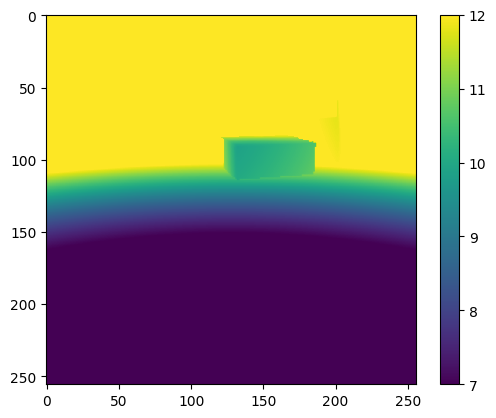

In [84]:
import matplotlib.pyplot as plt

t = 0
plt.imshow(data_stack["depth"][t][...,0], vmin=7, vmax=12.)
# plt.imshow(data_stack["depth"][0][...,0])
plt.colorbar()

In [85]:
data_stack["depth"].shape

(5, 256, 256, 1)

In [86]:
metadata["camera"].keys()

dict_keys(['focal_length', 'sensor_width', 'field_of_view', 'positions', 'quaternions', 'K', 'R'])

In [87]:
metadata['camera']['focal_length']

35.0

In [88]:
256/32

8.0

In [89]:
K = metadata["camera"]["K"]
K


array([[ 1.09375,  0.     , -0.5    ],
       [ 0.     , -1.09375, -0.5    ],
       [ 0.     ,  0.     , -1.     ]])

In [90]:
K, np.linalg.inv(K),np.linalg.inv(K.T)==np.linalg.inv(K).T

(array([[ 1.09375,  0.     , -0.5    ],
        [ 0.     , -1.09375, -0.5    ],
        [ 0.     ,  0.     , -1.     ]]),
 array([[ 0.91428571,  0.        , -0.45714286],
        [-0.        , -0.91428571,  0.45714286],
        [-0.        , -0.        , -1.        ]]),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [91]:
def unproject_depth(depth, intrinsics):
    """Unprojects a depth image into a point cloud.
    
    Args:
        depth (jnp.ndarray): The depth image. Shape (H, W)
        intrinsics (b.camera.Intrinsics): The camera intrinsics.
    Returns:
        jnp.ndarray: The point cloud. Shape (H, W, 3)
    """
    mask = (depth < intrinsics.far) * (depth > intrinsics.near)
    depth = depth * mask + intrinsics.far * (1.0 - mask)
    y, x = np.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = np.stack([x, y, np.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [92]:
# unproject_depth(data_stack["depth"][t], intrinsics)

In [127]:
np.ones((2,3,4)).T.shape

(4, 3, 2)

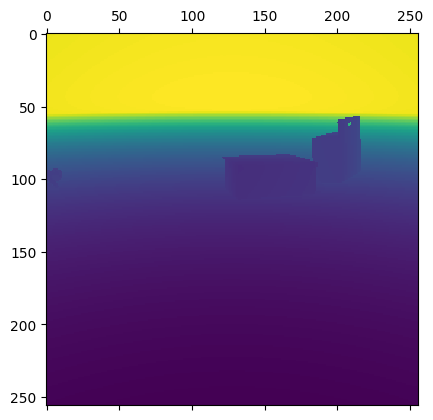

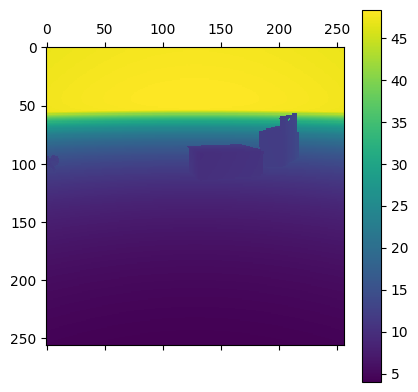

In [163]:
t = 0
n = 256

# Kubric works with "normalized" image coordinates $u,v \in [0,1]$
# The intrinsic matrix is given by
# ```
#       K =[[f/W   0  -0.5 ]
#           [ 0  -f/H -0.5 ]
#           [ 0    0  -1.0 ]]
# ```
# where W,H are the sensor width and height and f is the focal length. 
# Image coordinates (u,v) and Camera coordinates (x,y,z) are related as follows:
# ```
#       -z  * (u,v,1)^T =  K * (x,y,z)^T
# ```
# ...
# > https://github.com/google-research/kubric/blob/main/kubric/core/cameras.py#L23
def z_to_xyz(z, img_shape, K):
    h, w, _ = z.shape[-3:] 
    uv  = np.stack(np.meshgrid(np.linspace(1,0, w), np.linspace(0,1, h), indexing="ij"), axis=0)
    uv1 = np.concatenate([uv, np.ones((1,w,h))], axis=0)
    z   = data_stack["depth"][t].T
    xyz = np.linalg.inv(K)@(-z*uv1).reshape(3,-1)
    return xyz.reshape(3,w,h).T

# uv  = 1.*np.stack(np.meshgrid(np.linspace(0,1, n), np.linspace(0, 1, n)), axis=-1).reshape(-1,2)
# uv1 = np.concatenate([uv, np.ones((n**2,1))], axis=-1)
# z   = data_stack["depth"][t].reshape(-1,1)
# xyz = (-z*uv1)@(np.linalg.inv(K).T)
# xyz = xyz.reshape(n,n,3) 



im = z_to_xyz(data_stack["depth"][t], (n,n), K)
plt.matshow(im[...,2])
plt.matshow(data_stack["depth"][t])
plt.colorbar()

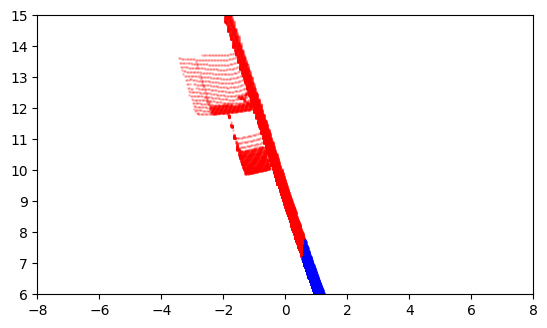

In [162]:
plt.gca().set_aspect(1)
plt.ylim(6,15)
plt.xlim(-8,8)
for i in np.arange(0,150, step=1):
    plt.scatter(im[i,:,1], im[i,:,2], s= 1, alpha=0.2, c="r")

for i in np.arange(150,256, step=1):
    plt.scatter(im[i,:,1], im[i,:,2], s= 1, alpha=0.2, c="b")